## **Brain Stroke Image classification**
---

### **Solved by:**
- Team Name: *Mission AI*
- Team Members: *Bhargav, Bipul, Dinesh, Saikat, Sajit*
- Date: *11/04/2023*

## Importing

In [ ]:
import pathlib
import numpy as np
import pandas as pd
import os
import shutil
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

## Segregating the images
 - We have converted the DICOM files into JPG images manually using the tool "Radiantviewer".
 - Using the below code we have seggregated the converted images in "Positive" and "Negative" folders as per the labels provided in the "Stroke _DCM _Train_Labels.xlsx" file.

In [ ]:
# Create a list of positive and Negative indices 

labels_file = pd.read_excel('/Users/sajitshankar/tensorflow-test/IITG /HACKATHON 2/Stroke _DCM _Train_Labels.xlsx',header=[1],nrows=108)

def get_positive_index(x):
    if "," in x:
        start = x.split(" , ")
        index_1 = list(np.arange(int(start[0].split(" to ")[0]),int(start[0].split(" to ")[1])+1))
        index_2 = list(np.arange(int(start[1].split(" to ")[0]),int(start[1].split(" to ")[1])+1))
        return index_1 + index_2
    else:
        return list(np.arange(int(x.split(" to ")[0]),int(x.split(" to ")[1])+1))
    
def get_negative_index(count,positive_index_val):
    total_range = list(np.arange(1,count+1))
    index = [i for i in total_range if i not in list(positive_index_val)]
    return index
    
labels_file["positive_index"] = labels_file["Positive"].apply(lambda x: get_positive_index(x))
labels_file["negative_index"] = labels_file[["Unnamed: 2","positive_index"]].apply(lambda x: get_negative_index(x["Unnamed: 2"],x["positive_index"]),axis=1)

# QC step
labels_file["postive_count_QC"] = labels_file["positive_index"].apply(lambda x: len(x))
labels_file["negative_count_QC"] = labels_file["negative_index"].apply(lambda x: len(x))

# rename the columns
labels_file.rename(columns={"Unnamed: 0":"ID"},inplace=True)
labels_file.rename(columns={"Unnamed: 1":"IMAGE NAME"},inplace=True)
labels_file.rename(columns={"Unnamed: 2":"IMAGE COUNT"},inplace=True)

In [ ]:
labels_file.head()

,ID,IMAGE NAME,IMAGE COUNT,Positive,Total Positive,Negative,positive_index,negative_index,postive_count_QC,negative_count_QC
0,1,STP21,50,26 to 44,19,31,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",19,31
1,2,STP22,50,26 to 46,21,29,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",21,29
2,3,STP23,50,26 to 42,17,33,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",17,33
3,4,STP24,50,26 to 46,21,29,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",21,29
4,5,STP25,50,26 to 45,20,30,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",20,30


In [ ]:
# Seggregating stroke_yes images in positive folder and stroke_no images in negative folder

parent_folder = '/Users/sajitshankar/tensorflow-test/IITG /HACKATHON 2/STOKE IMAGE_JPG_FINAL'

# Create the destination folders
pos_folder = os.path.join(parent_folder, 'positive')
neg_folder = os.path.join(parent_folder, 'negative')
os.makedirs(pos_folder, exist_ok=True)
os.makedirs(neg_folder, exist_ok=True)

# Iterate through subfolders
for subfolder in tqdm(os.listdir(parent_folder)):
    subfolder_path = os.path.join(parent_folder, subfolder)
    subfolder_path = os.path.join(subfolder_path, "STUDY")
    if os.path.isdir(subfolder_path) and subfolder not in ['positive', 'negative']:
        
        # Iterate through files in the subfolder
        files = [f for f in os.listdir(subfolder_path) if f.lower().endswith('.jpg')]
        files.sort()
        
        pos_list = labels_file[labels_file["IMAGE NAME"]==subfolder]["positive_index"].values[0]
        neg_list = labels_file[labels_file["IMAGE NAME"]==subfolder]["negative_index"].values[0]
        
        # Now, the files list is sorted in the sequence of the images
        for index, file in enumerate(files, start=1):
            file_path = os.path.join(subfolder_path, file)
            
            if index in pos_list:
                dest_path = os.path.join(pos_folder, subfolder+"_"+file)
                shutil.move(file_path, dest_path)
                
            elif index in neg_list:
                dest_path = os.path.join(neg_folder, subfolder+"_"+file)
                shutil.move(file_path, dest_path)

## Exploring the data

### Analyzing data to understand whether data is balanced or not.

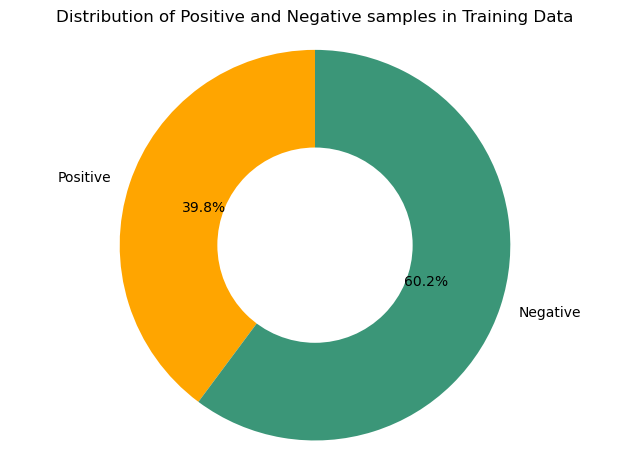

In [ ]:

# Pie chart data
sizes = [labels_file["postive_count_QC"].sum(), labels_file["negative_count_QC"].sum()]
labels = ['Positive', 'Negative']
colors = ['orange','#3b9678']

# Create pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Draw white circle in the center
center_circle = plt.Circle((0, 0), 0.5, fc='white')
fig.gca().add_artist(center_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
plt.title('Distribution of Positive and Negative samples in Training Data')
plt.tight_layout()
plt.show()


Positives are 39.8% and Negatives are 60.2% in the training data.
Data is slighlty imbalanced.

### Analyzing frequency of positive indices (MRI slices)

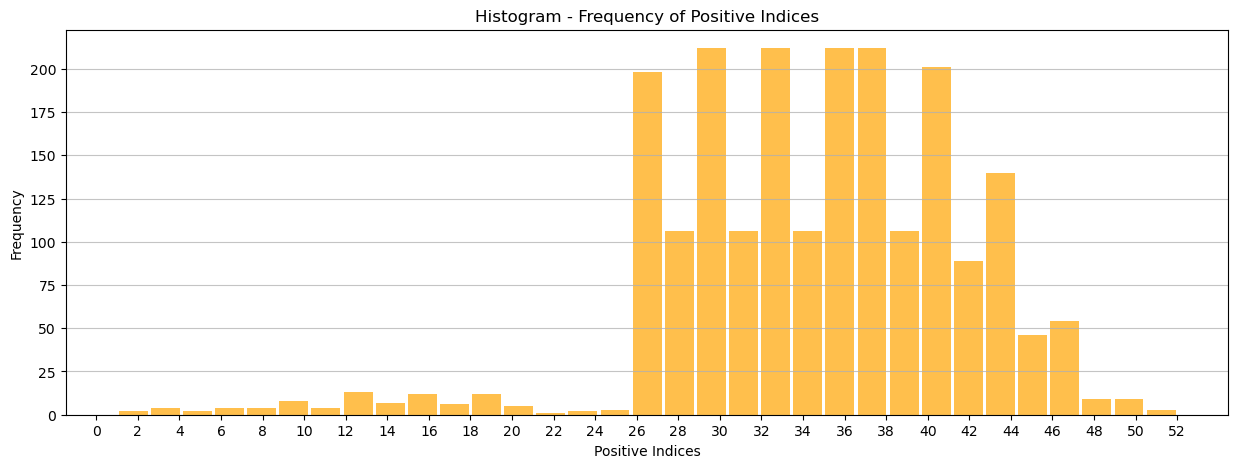

In [ ]:
# Extract positive index data
positive_indices = labels_file["positive_index"].explode()

# Create histogram
fig = plt.figure(figsize=(15,5))
plt.hist(positive_indices, bins='auto', color='orange', alpha=0.7, rwidth=0.9)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Positive Indices')
plt.ylabel('Frequency')
plt.title('Histogram - Frequency of Positive Indices')

# Decrease step size on x-axis
min_value = 0
max_value = int(np.max(positive_indices))
step_size = 2  # Adjust this value to change the step size
plt.xticks(np.arange(min_value, max_value+1, step_size))

plt.show()


From the above histogram it could be inferred that the frequency of positives are very high between 26 to 44.

## Loading the images

In [ ]:
data_dir = pathlib.Path("/Users/sajitshankar/tensorflow-test/IITG /HACKATHON 2/STOKE IMAGE_JPG_FINAL")

In [ ]:
# training data
train_positive_images = list(data_dir.glob('positive/*.jpg'))
train_negative_images = list(data_dir.glob('negative/*.jpg'))

In [ ]:
print(f"Total # of positive images: {len(train_positive_images)}\nTotal # of negative images: {len(train_negative_images)}")

Total # of positive images: 2110
Total # of negative images: 3188


## Preprocessing
 - Resizing the image resolution

In [ ]:
# setting image parameters
IMAGE_WIDTH = 170
IMAGE_HEIGHT = 170
IMAGE_COLOR_CHANNELS = 3  # RGB

# encoding labels
labels_dict = {
  'negative': 0,
  'positive': 1,
}

In [ ]:
# preprocessing function
def get_image_array(positive_images,negative_images,IMAGE_WIDTH=128,IMAGE_HEIGHT=128):
  """
  This function resizes the images
  and converts it to an numpy array and
  returns it along with the class labels
  """
  images_dict = {
    'positive': positive_images,
    'negative': negative_images,
  }
  X, y = [], []

  for image_type, images in images_dict.items():
    for image in images:
      img = cv2.imread(str(image))
      if isinstance(img,type(None)): 
        pass
          
      elif ((img.shape[0] >= IMAGE_HEIGHT) and  (img.shape[1] >=IMAGE_WIDTH)):
        resized_img = cv2.resize(img,(IMAGE_WIDTH,IMAGE_HEIGHT))
        X.append(resized_img)
        y.append(labels_dict[image_type])
      else:
        pass
  X = np.array(X)
  y = np.array(y)

  return X,y

In [ ]:
X, y = get_image_array(train_positive_images,train_negative_images,IMAGE_WIDTH,IMAGE_HEIGHT)

## Train-Validation Split
- Splitting the datset into train & validation using 80-20 split

In [ ]:
# train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(f"Train array shape: {X_train.shape}")
print(f"Test array shape: {X_val.shape}")

Train array shape: (4238, 170, 170, 3)
Test array shape: (1060, 170, 170, 3)


## Model
 - Building the CNN Model

In [ ]:
# fixing the seed to reproduce consistent results

def set_seed(seed_value):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)
    tf.random.set_seed(seed_value)

SEED_VALUE = 42
set_seed(SEED_VALUE)

In [ ]:
# Define a custom F1-score function
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [ ]:
# CNN model
model = keras.models.Sequential(
  [
    # input layer
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_COLOR_CHANNELS)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    # hidden layer 1
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    # hidden layer 2
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    # output layer
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid'),
  ]
)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=f1_score)
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 168, 168, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 168, 168, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 84, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 84, 84, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 82, 82, 64)        18496     
                                         

2023-04-11 23:55:51.382482: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-11 23:55:51.382600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


 dense (Dense)               (None, 512)               23659008  
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 23,755,713
Trainable params: 23,754,241
Non-trainable params: 1,472
_________________________________________________________________


### Fitting the model

In [ ]:
result = []
for i in range(2):
    print(f"Iteration {i}")
    result.append(model.fit(X_train, y_train, epochs=15))

Iteration 0
Epoch 1/15


2023-04-11 23:56:14.857175: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-11 23:56:15.287315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


133/133 [==============================] - 12s 79ms/step - loss: 0.4975 - f1_score: 0.7245
Epoch 2/15
133/133 [==============================] - 10s 76ms/step - loss: 0.3183 - f1_score: 0.8365
Epoch 3/15
133/133 [==============================] - 10s 77ms/step - loss: 0.2788 - f1_score: 0.8575
Epoch 4/15
133/133 [==============================] - 10s 74ms/step - loss: 0.2411 - f1_score: 0.8842
Epoch 5/15
133/133 [==============================] - 10s 75ms/step - loss: 0.2172 - f1_score: 0.8950
Epoch 6/15
133/133 [==============================] - 10s 74ms/step - loss: 0.2114 - f1_score: 0.8966
Epoch 7/15
133/133 [==============================] - 10s 74ms/step - loss: 0.2036 - f1_score: 0.8959
Epoch 8/15
133/133 [==============================] - 10s 75ms/step - loss: 0.1936 - f1_score: 0.9121
Epoch 9/15
133/133 [==============================] - 10s 76ms/step - loss: 0.1791 - f1_score: 0.9108
Epoch 10/15
133/133 [==============================] - 10s 74ms/step - loss: 0.1569 - f1_scor

### Model Evaluation

In [ ]:
train_loss,train_f1 = model.evaluate(X_train,y_train,verbose=0)
val_loss,val_f1 = model.evaluate(X_val,y_val,verbose=0)

print(f"Training Loss: {round(100*train_loss,2)}% , Training f1-score: {round(train_f1,2)}")
print(f"Validaton Loss: {round(100*val_loss,2)}% , Validaton f1-score: {round(val_f1,2)}")

2023-04-12 00:01:14.714244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Training Loss: 12.92% , Training f1-score: 0.97
Validaton Loss: 26.4% , Validaton f1-score: 0.91


In [ ]:
# getting test predictions
y_pred = model.predict(X_val,verbose=0)

cuttoff = 0.5 # setting a cutt-off value for the prediction class
y_pred_classes = [0 if value < cuttoff else 1 for value in y_pred]

# generating the classification report
print("Classification Report:")
display(pd.DataFrame(classification_report(y_val, y_pred_classes,output_dict=True)).T)

2023-04-12 00:01:19.023497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification Report:


,precision,recall,f1-score,support
0,0.982270,0.886400,0.931876,625.000000
1,0.856855,0.977011,0.912997,435.000000
accuracy,0.923585,0.923585,0.923585,0.923585
macro avg,0.919562,0.931706,0.922436,1060.000000
weighted avg,0.930802,0.923585,0.924128,1060.000000


Confusion Matrix:


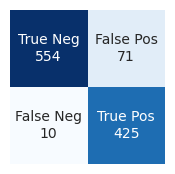

In [ ]:
# generating the confusion matrix
cf_matrix = confusion_matrix(y_val, y_pred_classes)

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

fig = plt.figure(figsize=(2,2))
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues',cbar=False,xticklabels=False, yticklabels=False)
print("Confusion Matrix:")
plt.show()

F1-score & Loss vs. Epoch


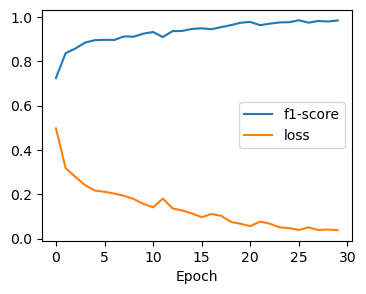

In [ ]:
# plotting loss & f1-score vs. epoch
f1_scores = result[0].history['f1_score'] + result[1].history['f1_score']
loss = result[0].history['loss'] + result[1].history['loss']

fig = plt.figure(figsize=(4,3))
plt.plot(f1_scores, label='f1-score')  
plt.plot(loss, label='loss')
plt.xlabel('Epoch')
plt.legend(loc='center right')
print("F1-score & Loss vs. Epoch")
plt.show()

### Test data prediction

In [ ]:
# loading the test data
test_data_dir = pathlib.Path("/Users/sajitshankar/tensorflow-test/IITG /HACKATHON 2/test_data")
test_images = list(test_data_dir.glob('Test_V1/*.jpg'))

print("Total number of test data: ",len(test_images))

Total number of test data:  175


In [ ]:
# preprocessing the test data

X_test = []
file_name = []

for image in test_images:
      img = cv2.imread(str(image))
      if isinstance(img,type(None)): 
        pass
          
      elif ((img.shape[0] >= IMAGE_HEIGHT) and  (img.shape[1] >=IMAGE_WIDTH)):
        resized_img = cv2.resize(img,(IMAGE_WIDTH,IMAGE_HEIGHT))
        X_test.append(resized_img)
        file_name.append(str(image).split("/")[-1].replace(".jpg",""))
      else:
        pass
    
X_test = np.array(X_test)

In [ ]:
# getting test predictions
y_pred_test = model.predict(X_test,verbose=0)

cuttoff = 0.5 # setting a cutt-off value for the prediction class
y_pred_test_classes = [0 if value < cuttoff else 1 for value in y_pred_test]

In [ ]:
# checking the ratio of the classes in test data
pd.Series(y_pred_test_classes).value_counts(normalize=True)

1    0.514286
0    0.485714
dtype: float64

In [ ]:
# exporting the test predictions
sample_submission_df = pd.concat([pd.Series(file_name),pd.Series(y_pred_test_classes)],axis=1).rename(columns={0:"SN",1:"Label"})
sample_submission_df["SN"] = sample_submission_df["SN"].astype("int")
sample_submission_df.sort_values(by=["SN"],inplace=True)
sample_submission_df.reset_index(drop=True,inplace=True)

In [ ]:
sample_submission_df.head(50)

,SN,Label
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
5,6,1
6,7,1
7,8,1
8,9,1
9,10,1


In [ ]:
sample_submission_df.to_csv("/Users/sajitshankar/tensorflow-test/IITG /HACKATHON 2/sample_test_label_brain_stroke_v3_final.csv",index=False)